#### Experiment: 

Compare bayesian optimization experiments with random hyperparameter search

#### Motivation.

Evaluate bayesian optimization as a hyperparameter search tool

#### Conclusion


In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import glob
import tabulate
import pprint
import click
import numpy as np
import pandas as pd
from ray.tune.commands import *
from nupic.research.frameworks.dynamic_sparse.common.browser import *
import re

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams

%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set(style="whitegrid")
sns.set_palette("colorblind")

## Load and check data

In [3]:
exps = ['sigopt_baseline_comp', 'test_sigopt.py']
paths = [os.path.expanduser("~/nta/results/{}".format(e)) for e in exps]
df = load_many(paths)

In [32]:
test_string = '0_learning_'
re.match('^\d+', test_string)[0]

'0'

In [31]:
df.head(5)

,Experiment Name,train_acc_max,train_acc_max_epoch,train_acc_min,train_acc_min_epoch,train_acc_median,train_acc_last,val_acc_max,val_acc_max_epoch,val_acc_min,...,model,name,network,num_classes,on_perc,stats_mean,stats_std,experiment_type,params_space,performance_metric
0,"0_learning_rate=0.0057896,on_perc=0.32882",0.91818,9,0.49662,0,0.81512,0.91818,0.7143,9,0.5764,...,SparseModel,sigopt_baseline_comp,resnet18,10,0.328820,0.473367,0.2009,NaN,NaN,NaN
1,"1_learning_rate=0.13991,on_perc=0.52182",0.86278,9,0.35546,0,0.73908,0.86278,0.7202,8,0.4488,...,SparseModel,sigopt_baseline_comp,resnet18,10,0.521823,0.473367,0.2009,NaN,NaN,NaN
2,"2_learning_rate=0.1937,on_perc=0.71132",0.75688,9,0.28814,0,0.62464,0.75688,0.6991,9,0.3903,...,SparseModel,sigopt_baseline_comp,resnet18,10,0.711315,0.473367,0.2009,NaN,NaN,NaN
3,"3_learning_rate=0.014079,on_perc=0.99743",0.92836,9,0.47330,0,0.81634,0.92836,0.7424,9,0.5751,...,SparseModel,sigopt_baseline_comp,resnet18,10,0.997429,0.473367,0.2009,NaN,NaN,NaN
4,"4_learning_rate=0.11306,on_perc=0.97861",0.82902,9,0.32164,0,0.70090,0.82902,0.7131,8,0.4330,...,SparseModel,sigopt_baseline_comp,resnet18,10,0.978613,0.473367,0.2009,NaN,NaN,NaN


In [5]:
df.columns

Index(['Experiment Name', 'train_acc_max', 'train_acc_max_epoch',
       'train_acc_min', 'train_acc_min_epoch', 'train_acc_median',
       'train_acc_last', 'val_acc_max', 'val_acc_max_epoch', 'val_acc_min',
       'val_acc_min_epoch', 'val_acc_median', 'val_acc_last', 'val_acc_all',
       'epochs', 'experiment_file_name', 'trial_time', 'mean_epoch_time',
       'batch_size_test', 'batch_size_train', 'checkpoint_dir', 'data_dir',
       'dataset_name', 'device', 'input_size', 'learning_rate', 'local_dir',
       'model', 'name', 'network', 'num_classes', 'on_perc', 'stats_mean',
       'stats_std', 'experiment_type', 'params_space', 'performance_metric'],
      dtype='object')

In [13]:
df['experiment_file_name'].unique()

array(['Random Search', 'SigOpt-A', 'SigOpt-B'], dtype=object)

In [11]:
def fix_name(s):
    if s == '/Users/lsouza/nta/results/sigopt_baseline_comp/experiment_state-2020-03-16_03-33-36.json':
        return 'Random Search'
    elif s == '/Users/lsouza/nta/results/test_sigopt.py/experiment_state-2020-03-15_23-03-55.json':
        return "SigOpt-A"
    elif s == '/Users/lsouza/nta/results/test_sigopt.py/experiment_state-2020-03-16_01-05-45.json':
        return "SigOpt-B"

df['experiment_file_name'] = df['experiment_file_name'].apply(fix_name)

In [12]:
df['experiment_file_name'].unique()

array(['Random Search', 'SigOpt-A', 'SigOpt-B'], dtype=object)

In [100]:
def get_index(s):
    return int(re.match('^\d+', s)[0])

df['index_pos'] = df['Experiment Name'].apply(get_index)

In [143]:
df['density'] = df['on_perc']

In [101]:
df.iloc[17]

Experiment Name                17_learning_rate=0.0072931,on_perc=0.68856
train_acc_max                                                     0.93018
train_acc_max_epoch                                                     9
train_acc_min                                                      0.4897
train_acc_min_epoch                                                     0
train_acc_median                                                  0.82547
train_acc_last                                                    0.93018
val_acc_max                                                        0.7311
val_acc_max_epoch                                                       9
val_acc_min                                                        0.5663
val_acc_min_epoch                                                       0
val_acc_median                                                     0.7029
val_acc_last                                                       0.7311
val_acc_all             0    0.5663
1 

In [39]:
df.groupby('experiment_file_name')['model'].count()

experiment_file_name
Random Search    100
SigOpt-A         100
SigOpt-B         100
Name: model, dtype: int64

 ## Analysis

In [40]:
# helper functions
def mean_and_std(s):
    return "{:.3f} ± {:.3f}".format(s.mean(), s.std())

def round_mean(s):
    return "{:.0f}".format(round(s.mean()))

stats = ['min', 'max', 'mean', 'std']

def agg(columns, filter=None, round=3):
    if filter is None:
        return (df.groupby(columns)
             .agg({'val_acc_max_epoch': round_mean,
                   'val_acc_max': stats,                
                   'model': ['count']})).round(round)
    else:
        return (df[filter].groupby(columns)
             .agg({'val_acc_max_epoch': round_mean,
                   'val_acc_max': stats,                
                   'model': ['count']})).round(round)


In [41]:
agg(['experiment_file_name'])

val_acc_max_epoch val_acc_max                      model
                            round_mean         min    max   mean    std count
experiment_file_name                                                         
Random Search                        8       0.694  0.752  0.722  0.013   100
SigOpt-A                             8       0.682  0.755  0.736  0.013   100
SigOpt-B                             8       0.688  0.756  0.737  0.011   100

In [109]:
def plot_acc_over_time(plot_title):
    plt.figure(figsize=(12,6))
    df_plot = df[df['experiment_file_name'] == plot_title]
    sns.lineplot(df_plot['index_pos'], y=df_plot['val_acc_last'])
    plt.xticks(np.arange(0,100,5))
    plt.ylim(0.67,0.76)
    plt.title(plot_title)

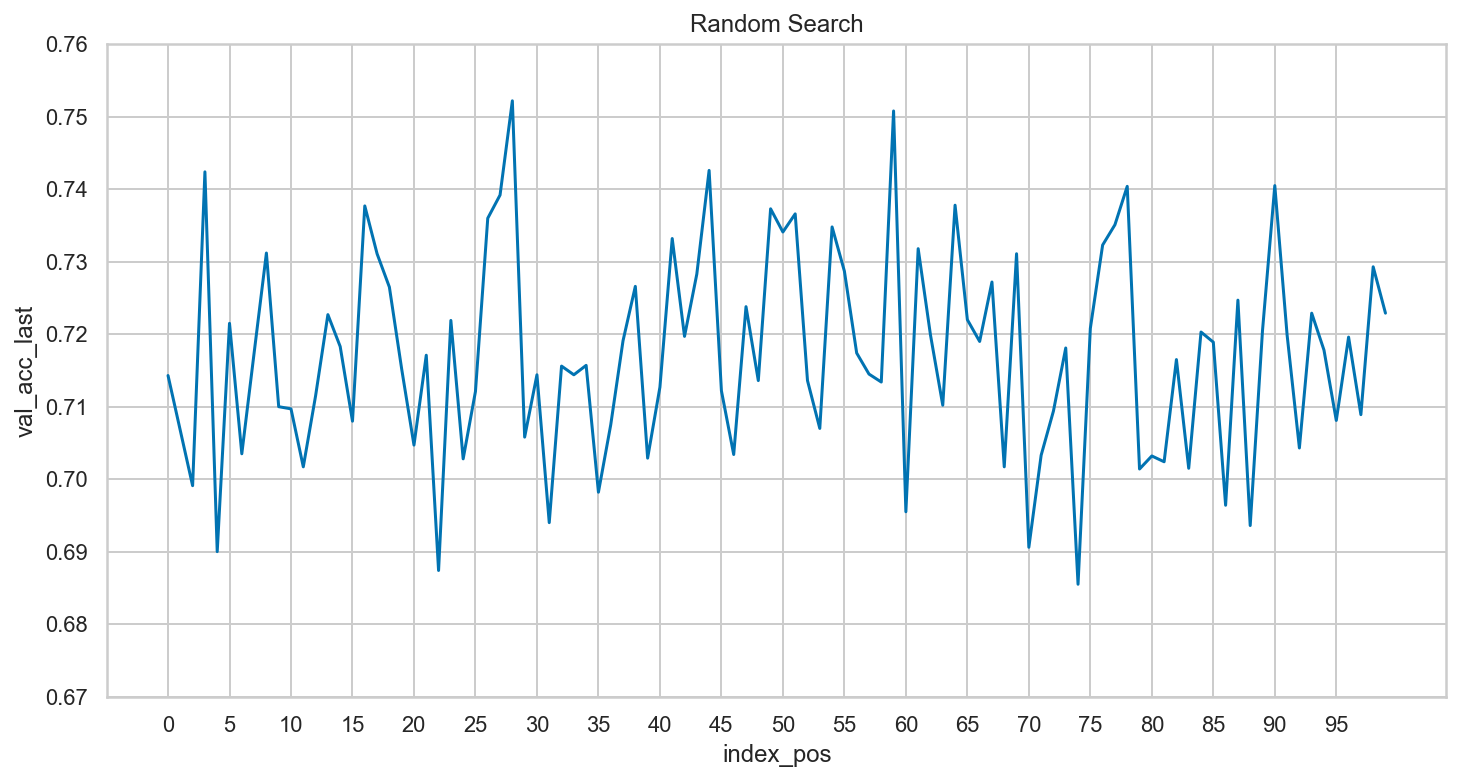

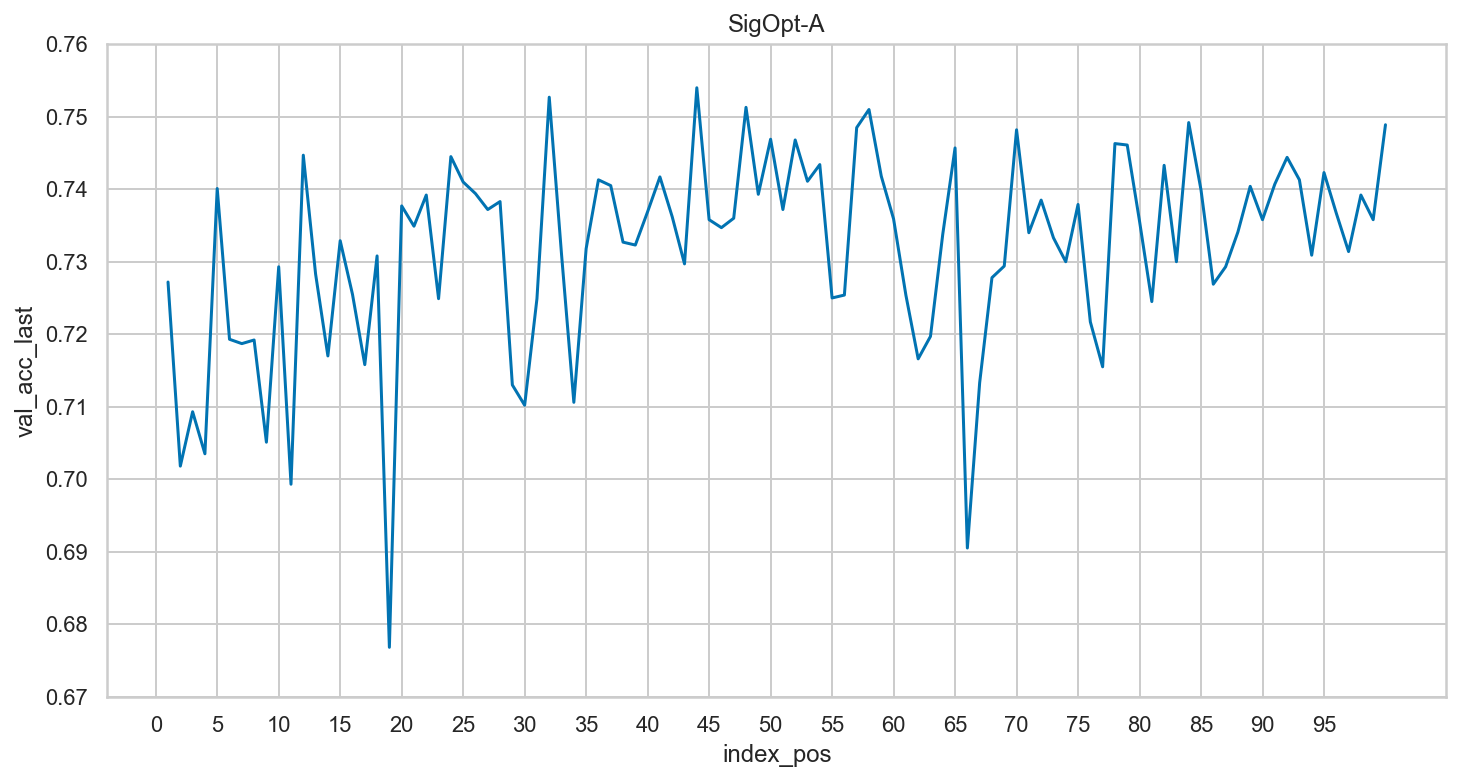

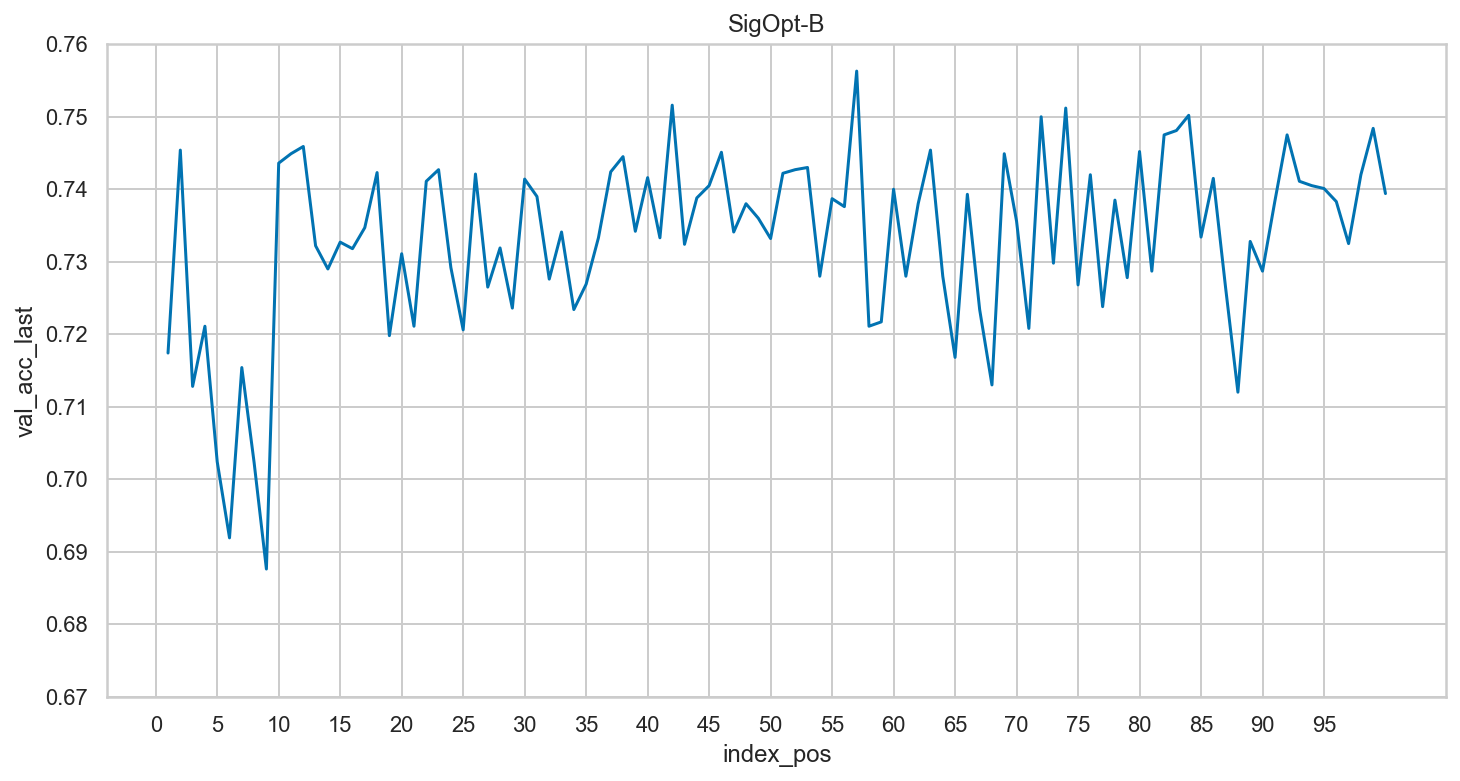

In [121]:
# how to plot?
plot_acc_over_time('Random Search')
plot_acc_over_time('SigOpt-A')
plot_acc_over_time('SigOpt-B')

In [141]:
def accumulate(series):
    series = list(series)
    cum_series = [series[0]]
    for i in range(1, len(series)):
        cum_series.append(max(cum_series[i-1], series[i]))
    return cum_series   

def plot_best_acc_over_time(plot_title):
    plt.figure(figsize=(12,6))
    df_plot = df[df['experiment_file_name'] == plot_title].sort_values('index_pos')
    df_plot['cum_acc'] = accumulate(df_plot['val_acc_last'])
    sns.lineplot(df_plot['index_pos'], y=df_plot['cum_acc'])
    plt.xticks(np.arange(0,101,5))
    plt.ylim(0.71,0.76)
    plt.title(plot_title)

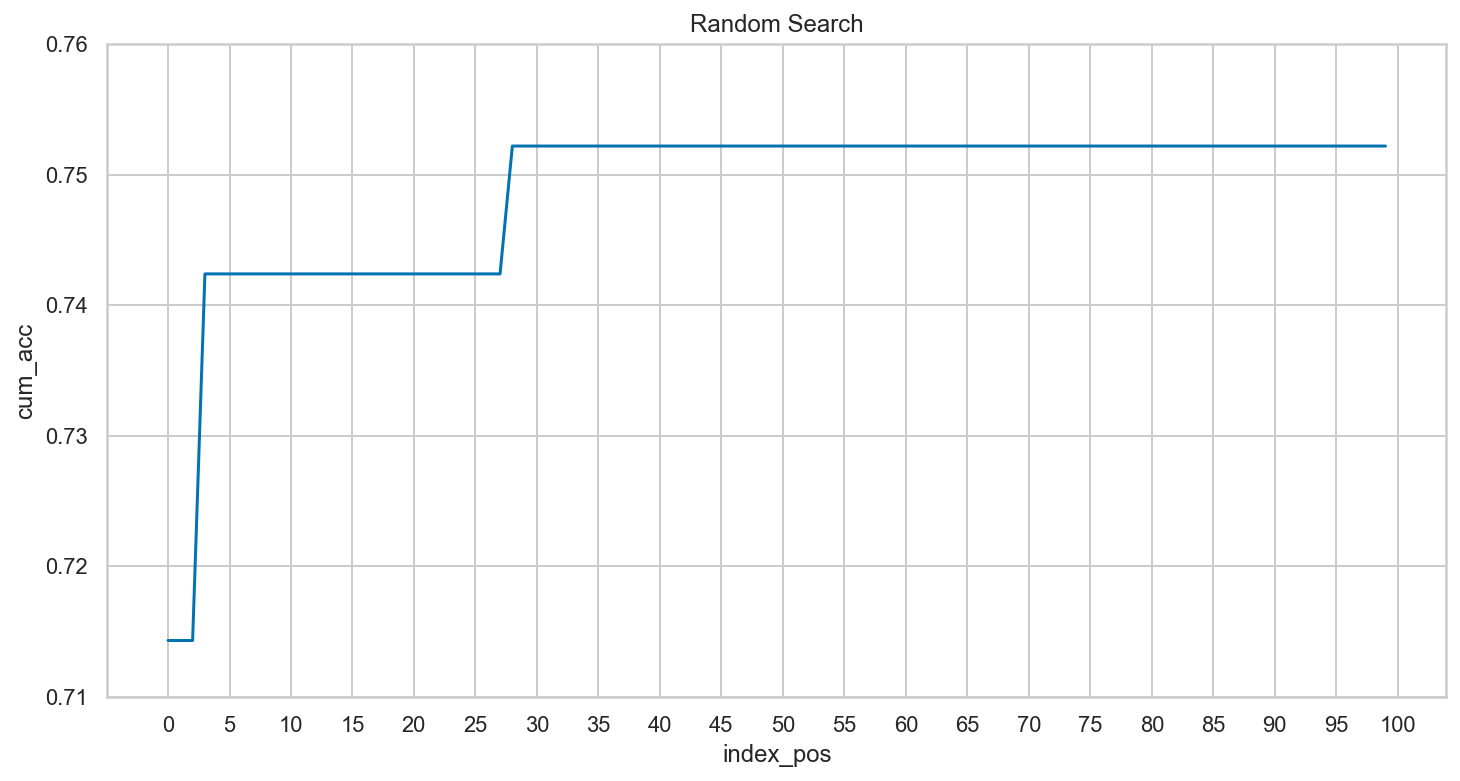

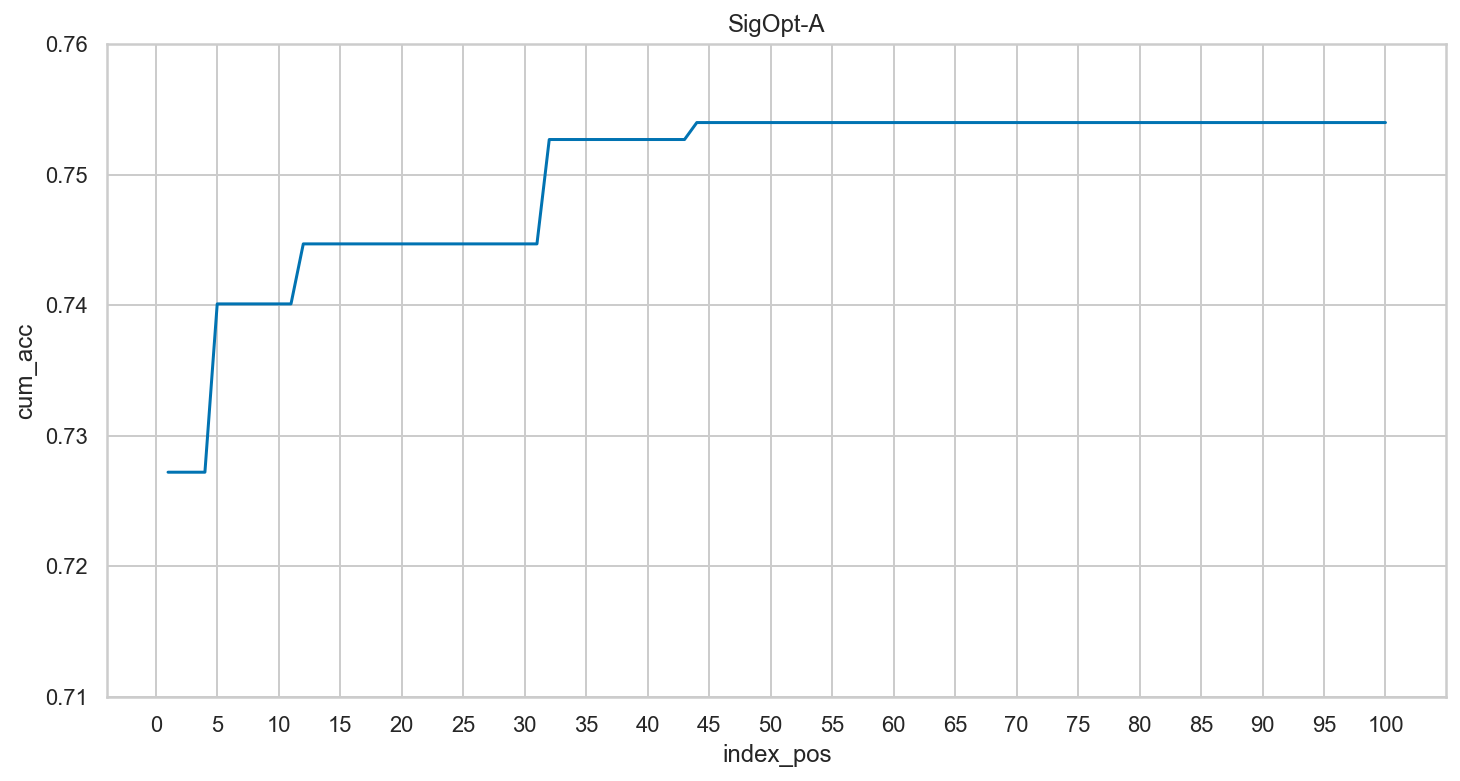

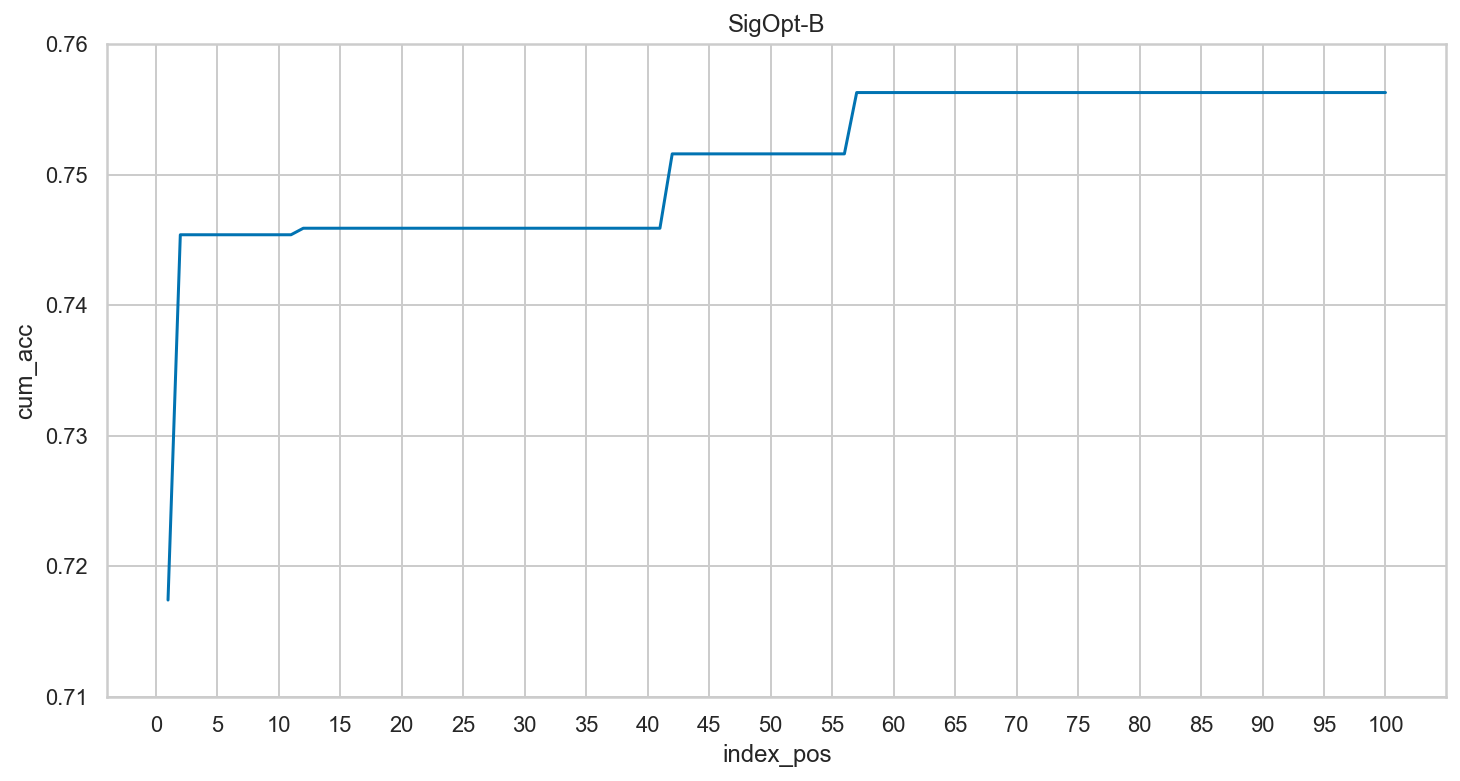

In [142]:
plot_best_acc_over_time('Random Search')
plot_best_acc_over_time('SigOpt-A')
plot_best_acc_over_time('SigOpt-B')

In [152]:
# list top 5 values of each
# show best values
def show_best(experiment):
    df_exp = df[df['experiment_file_name'] == experiment].sort_values('val_acc_last', ascending=False)[:5]
    return df_exp[['index_pos', 'learning_rate', 'density', 'val_acc_last']]

In [153]:
show_best('Random Search')

,index_pos,learning_rate,density,val_acc_last
28,28,0.026649,0.878527,0.7522
59,59,0.047101,0.947805,0.7508
44,44,0.032397,0.893441,0.7426
3,3,0.014079,0.997429,0.7424
90,90,0.052555,0.783216,0.7405


In [154]:
show_best('SigOpt-A')

,index_pos,learning_rate,density,val_acc_last
143,44,0.047389,0.780053,0.7540
131,32,0.047302,0.693954,0.7527
147,48,0.052172,0.854194,0.7513
157,58,0.034750,0.712643,0.7510
183,84,0.032677,0.720800,0.7492


In [155]:
show_best('SigOpt-B')

,index_pos,learning_rate,density,val_acc_last
256,57,0.042218,0.628306,0.7563
241,42,0.039869,0.633952,0.7516
273,74,0.048086,0.633737,0.7512
283,84,0.037110,0.832327,0.7502
271,72,0.060020,0.509682,0.7500
